In [9]:
import pandas as pd 
import seaborn as sns
import numpy as np

In [10]:
def load_data():
    data = pd.read_csv('titanic/train.csv')
    return data

In [11]:
def clean_of_na(df):
    res = df.columns[df.isna().any()].tolist()
    df = df.fillna(0)
    hash_table = []
    for i in res:
        c = {}
        t = 1
        if i == 'Age':
            pass
        elif i == 'Cabin':
            for j in df[i]:
                if j == 0:
                    j = 0
                else:
                    if j[0] in c:
                        j = c[j[0]]
                    else:
                        c[j[0]] = t
                        t+=1
        else:
            for j in df[i]:
                if j == 0:
                    j = 0
                else:
                    if j in c:
                        j = c[j]
                    else:
                        c[j] = t
                        t+=1
        hash_table.append(c)
    return df, hash_table



In [12]:
def val():
    return 1
def clean_of_str(data,ht):
    pdata = data.drop(['PassengerId', 'Name', 'Ticket'], axis=1)
    pdata['Sex'] = pdata['Sex'].replace(['male'], 0) 
    pdata['Sex'] = pdata['Sex'].replace(['female'], 1)
    pdata['Sex'] = pd.to_numeric(pdata['Sex'])
    pdata['Cabin'] = pdata.Cabin.replace(r'^C', 1, regex=True)
    pdata['Cabin'] = pdata.Cabin.replace(r'^E', 2, regex=True)
    pdata['Cabin'] = pdata.Cabin.replace(r'^G', 3, regex=True)
    pdata['Cabin'] = pdata.Cabin.replace(r'^D', 4, regex=True)
    pdata['Cabin'] = pdata.Cabin.replace(r'^A', 5, regex=True)
    pdata['Cabin'] = pdata.Cabin.replace(r'^B', 6, regex=True)
    pdata['Cabin'] = pdata.Cabin.replace(r'^F', 7, regex=True)
    pdata['Cabin'] = pdata.Cabin.replace(r'^T', 8, regex=True)
    pdata['Cabin'] = pd.to_numeric(pdata['Cabin'])
    pdata['Embarked'] = pdata.Embarked.replace(['S'], 1)
    pdata['Embarked'] = pdata.Embarked.replace(['C'], 2)
    pdata['Embarked'] = pdata.Embarked.replace(['Q'], 3)
    pdata['Embarked'] = pd.to_numeric(pdata['Embarked'])
    return pdata

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    int64  
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Cabin     891 non-null    int64  
 8   Embarked  891 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 62.8 KB


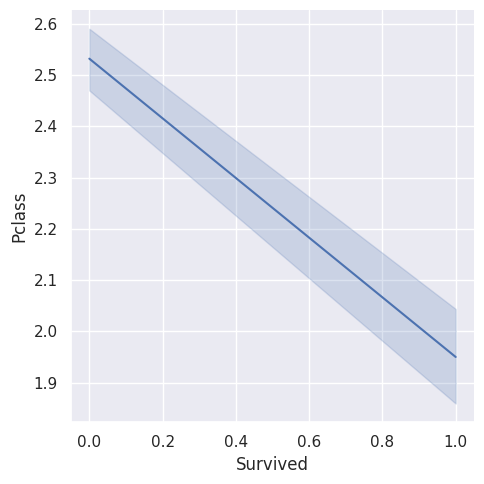

In [13]:
data = load_data()
# data.head()
pdata,ht = clean_of_na(data)
pdata = clean_of_str(pdata,ht)
pd.set_option('future.no_silent_downcasting', True)
sns.set_theme()
sns.relplot(pdata, x='Survived',y='Pclass' , kind='line')
pdata.info()
X_train = pdata.drop(['Survived'], axis=1)
Y_train = pdata['Survived']

In [14]:
import tensorflow as tf
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [15]:
model = keras.Sequential([
    keras.Input(shape=(8)),
    layers.Dense(32, activation = 'softmax'),
    layers.Dense(32, activation = 'softmax'),    
    layers.Dense(32, activation = 'softmax'),
    layers.Dense(32, activation = 'softmax'),    
    layers.Dense(32, activation = 'softmax'),    
    layers.Dense(32, activation = 'softmax'),    
    layers.Dense(32, activation = 'softmax'),            
    layers.Dense(1)
    ])
model.summary()
model.compile(
    loss = keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=keras.optimizers.AdamW(),
    metrics=["accuracy"],
)
model.fit(X_train, Y_train, batch_size=64, epochs=30, verbose=1)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 32)                288       
                                                                 
 dense_9 (Dense)             (None, 32)                1056      
                                                                 
 dense_10 (Dense)            (None, 32)                1056      
                                                                 
 dense_11 (Dense)            (None, 32)                1056      
                                                                 
 dense_12 (Dense)            (None, 32)                1056      
                                                                 
 dense_13 (Dense)            (None, 32)                1056      
                                                                 
 dense_14 (Dense)            (None, 32)               

2024-02-20 13:10:14.862937: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-20 13:10:15.137238: I external/local_xla/xla/service/service.cc:168] XLA service 0x7d8a6c7eed40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-20 13:10:15.137260: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2024-02-20 13:10:15.140844: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-02-20 13:10:15.151970: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1708434615.209132   53327 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


14/14 [==============================] - 2s 4ms/step - loss: 0.6932 - accuracy: 0.6162
Epoch 2/30
14/14 [==============================] - 0s 6ms/step - loss: 0.6900 - accuracy: 0.6162
Epoch 3/30
14/14 [==============================] - 0s 4ms/step - loss: 0.6868 - accuracy: 0.6162
Epoch 4/30
14/14 [==============================] - 0s 3ms/step - loss: 0.6840 - accuracy: 0.6162
Epoch 5/30
14/14 [==============================] - 0s 8ms/step - loss: 0.6816 - accuracy: 0.6162
Epoch 6/30
14/14 [==============================] - 0s 7ms/step - loss: 0.6792 - accuracy: 0.6162
Epoch 7/30
14/14 [==============================] - 0s 4ms/step - loss: 0.6775 - accuracy: 0.6162
Epoch 8/30
14/14 [==============================] - 0s 5ms/step - loss: 0.6756 - accuracy: 0.6162
Epoch 9/30
14/14 [==============================] - 0s 4ms/step - loss: 0.6743 - accuracy: 0.6162
Epoch 10/30
14/14 [==============================] - 0s 3ms/step - loss: 0.6730 - accuracy: 0.6162
Epoch 11/30
14/14 [===========

In [16]:
import sklearn
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
xgb_model = XGBClassifier()
xgb_model.fit(X_train[178:], Y_train[178:])
xgb_accuracy = xgb_model.score(X_train[:178], Y_train[:178])
print('XGBoost accuracy:', xgb_accuracy)

XGBoost accuracy: 0.7921348314606742


In [17]:
from sklearn.base import BaseEstimator, RegressorMixin

class KerasRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, model):
        self.model = model

    def fit(self, X, y):
        self.model.fit(X[178:], y[178:], epochs=10, validation_data=(X_train[:178], Y_train[:178]))  # Adjust epochs as needed
        return self

    def predict(self, X):
        return self.model.predict(X)



In [18]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'learning_rate': [0.01, 0.1, 1],
    'n_estimators': [100, 500, 1000],
    'max_depth': [3, 5, 8]
}

# Create and fit GridSearchCV object
xgb_grid = GridSearchCV(xgb_model, param_grid, cv=5)  # Adjust cv as needed
xgb_grid.fit(X_train, Y_train)
best_xgb_model = xgb_grid.best_estimator_
best_xgb_params = xgb_grid.best_params_

# Use the best model for predictions and stacking
xgb_train_preds = best_xgb_model.predict(X_train)

In [19]:
from sklearn.model_selection import cross_val_predict
nn_regressor = KerasRegressor(model)
xgb_train_preds = cross_val_predict(best_xgb_model, X_train, Y_train, cv=5)
nn_train_preds = cross_val_predict(nn_regressor, X_train, Y_train, cv=5)

Epoch 1/10
17/17 [==============================] - 2s 13ms/step - loss: 0.6652 - accuracy: 0.6180 - val_loss: 0.6427 - val_accuracy: 0.6685
Epoch 2/10
17/17 [==============================] - 0s 6ms/step - loss: 0.6652 - accuracy: 0.6180 - val_loss: 0.6425 - val_accuracy: 0.6685
Epoch 3/10
17/17 [==============================] - 0s 5ms/step - loss: 0.6652 - accuracy: 0.6180 - val_loss: 0.6424 - val_accuracy: 0.6685
Epoch 4/10
17/17 [==============================] - 0s 4ms/step - loss: 0.6651 - accuracy: 0.6180 - val_loss: 0.6420 - val_accuracy: 0.6685
Epoch 5/10
17/17 [==============================] - 0s 4ms/step - loss: 0.6652 - accuracy: 0.6180 - val_loss: 0.6416 - val_accuracy: 0.6685
Epoch 6/10
17/17 [==============================] - 0s 6ms/step - loss: 0.6651 - accuracy: 0.6180 - val_loss: 0.6415 - val_accuracy: 0.6685
Epoch 7/10
17/17 [==============================] - 0s 8ms/step - loss: 0.6651 - accuracy: 0.6180 - val_loss: 0.6414 - val_accuracy: 0.6685
Epoch 8/10
17/17 [=

In [20]:
# nn_train_preds = nn_train_preds[:, 0]  # Extract 0th dimension
# nn_train_preds = nn_train_preds.ravel() 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
print(np.shape(xgb_train_preds), np.shape(nn_train_preds[:,0].ravel()))
X_meta_train = pd.DataFrame({'xgb_preds': xgb_train_preds, 'nn_preds': nn_train_preds[:,0].ravel()})
meta_model = LogisticRegression()  # Example using logistic regression
meta_model.fit(X_meta_train, Y_train)
xgb_test_preds = xgb_model.predict(X_train[:178])
nn_test_preds = nn_regressor.predict(X_train[:178])
X_meta_test = pd.DataFrame({'xgb_preds': xgb_test_preds, 'nn_preds': nn_test_preds[:,0].ravel()})

# 7. Make final predictions using meta-model
final_preds = meta_model.predict(X_meta_test)

# Evaluate performance
accuracy = accuracy_score(Y_train[:178], final_preds)
print('Stacking model accuracy:', accuracy)

(891,) (891,)
6/6 [==============================] - 0s 1ms/step
Stacking model accuracy: 0.7921348314606742


In [22]:
import tensorflow_decision_forests as tfdf
model = tfdf.keras.RandomForestModel()
X_train = pdata.drop(['Survived'], axis=1)
Y_train = pdata['Survived']
df = [X_train, Y_train]
df = pd.concat(df, axis=1)
train_cs = df
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(df, label="Survived")

Use /tmp/tmpdae0hode as temporary training directory


In [23]:
import tensorflow_decision_forests as tfdf
model = tfdf.keras.RandomForestModel()
model.fit(train_ds)

Use /tmp/tmp78z9a1k4 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.964877. Found 891 examples.
Training model...
Model trained in 0:00:00.130478
Compiling model...


[INFO 24-02-20 13:12:29.3449 UTC kernel.cc:1233] Loading model from path /tmp/tmp78z9a1k4/model/ with prefix 8535fc95a2b34f0c
[INFO 24-02-20 13:12:29.3822 UTC decision_forest.cc:660] Model loaded with 300 root(s), 47816 node(s), and 8 input feature(s).
[INFO 24-02-20 13:12:29.3822 UTC abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 24-02-20 13:12:29.3822 UTC kernel.cc:1061] Use fast generic engine


Model compiled.


In [24]:
model.summary()

Model: "random_forest_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1 (1.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 1 (1.00 Byte)
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (8):
	Age
	Cabin
	Embarked
	Fare
	Parch
	Pclass
	Sex
	SibSp

No weights

Variable Importance: INV_MEAN_MIN_DEPTH:
    1.      "Sex"  0.532247 ################
    2.     "Fare"  0.298700 ######
    3.      "Age"  0.205154 ##
    4.    "Cabin"  0.188763 ##
    5.   "Pclass"  0.184580 ##
    6.    "SibSp"  0.136897 
    7.    "Parch"  0.136549 
    8. "Embarked"  0.132517 

Variable Importance: NUM_AS_ROOT:
    1.      "Sex" 162.000000 ################
    2.     "Fare" 54.000000 #####
    3.   "Pclass" 46.000000 ####
    4.    "Cabin" 32.000000 ###
    5. "Embarked"  4.000000 
    6.    "Parch

In [34]:
tdata = pd.read_csv('titanic/test.csv')
tdata, ht = clean_of_na(tdata)
tdata = clean_of_str(tdata, ht)
tdata.insert(8, 'Survived', pd.Series([0]*891))
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(tdata, label="Survived")
tdata

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Survived
0,3,0,34.5,0,0,7.8292,0,3,0
1,3,1,47.0,1,0,7.0000,0,1,0
2,2,0,62.0,0,0,9.6875,0,3,0
3,3,0,27.0,0,0,8.6625,0,1,0
4,3,1,22.0,1,1,12.2875,0,1,0
...,...,...,...,...,...,...,...,...,...
413,3,0,0.0,0,0,8.0500,0,1,0
414,1,1,39.0,0,0,108.9000,1,2,0
415,3,0,38.5,0,0,7.2500,0,1,0
416,3,0,0.0,0,0,8.0500,0,1,0


In [26]:
pred = model.predict(test_ds)

1/1 [==============================] - 0s 41ms/step


In [28]:
ans1 = np.round(pred)

tdata = pd.read_csv('titanic/test.csv')
final = pd.DataFrame(tdata['PassengerId'])
final.insert(1, 'Survived', ans1)
final['Survived'] = final['Survived'].astype('int')
final.to_csv('titanic/predictions.csv', index=False)

In [35]:
trainDS = train_cs
testDS = tdata
spl_test = trainDS[:178]
spl_train = trainDS[178:]

In [30]:
import ydf
model1 = ydf.GradientBoostedTreesLearner(label='Survived',num_trees=7000, growing_strategy='BEST_FIRST_GLOBAL', categorical_algorithm='RANDOM', split_axis='SPARSE_OBLIQUE', sparse_oblique_normalization='MIN_MAX', sparse_oblique_num_projections_exponent=1.0).train(spl_train)
model2 = ydf.RandomForestLearner(label='Survived',num_trees=70000, winner_take_all=True,categorical_algorithm='RANDOM', split_axis='SPARSE_OBLIQUE', sparse_oblique_normalization='MIN_MAX', sparse_oblique_num_projections_exponent=1.0 ).train(spl_train)

Train model on 713 examples


Model trained in 0:00:00.209430
Train model on 713 examples
Model trained in 0:00:11.826546


In [31]:
model2.describe()
# model2.describe()

In [32]:
model2.evaluate(spl_test)

Label \ Pred,0,1
0,104,17
1,15,42


In [36]:
pred = model2.predict(testDS)
ans = np.round(pred)

In [37]:
tdata = pd.read_csv('titanic/test.csv')
final = pd.DataFrame(tdata['PassengerId'])
final.insert(1, 'Survived', ans)
final['Survived'] = final['Survived'].astype('int')
final.to_csv('titanic/predictions.csv', index=False)